In [34]:
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import pandas as pd
import torch
import os
from glob import glob
from skimage import io, transform
from matplotlib import pyplot as plt

In [35]:
from importlib import reload
import modules.markush as md # custom module
import modules.patches as pt
reload(md) # Automatically reload changes made to custom module
reload(pt)

<module 'modules.patches' from '/home/thomas/Documents/IS-DS/Elsevier/MScThesis/modules/patches.py'>

In [36]:
# create MD dataset 
MD = md.MarkushDataset.from_dir('./data/training')

# split it into train and test, we stratify to make sure the classes are balanced
train_indices, test_indices = train_test_split(
    range(len(MD)),
    stratify=MD.data.label,
    test_size=0.1
)

MD_train = md.MarkushDataset.from_parent(MD, train_indices)
MD_test = md.MarkushDataset.from_parent(MD, test_indices)

In [37]:
# Specify random transforms

data_transforms = {
    'train': transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomPerspective(distortion_scale=0.25, fill=255),
    transforms.RandomPosterize(bits=4, p=0.25),
    transforms.RandomChoice([transforms.RandomAdjustSharpness(sharpness_factor=2, p=1), # Either sharpen or blur
                              transforms.RandomAdjustSharpness(sharpness_factor=0, p=1)]),
    transforms.ToTensor()
]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

In [38]:
# Create train and test patches sets

patches_train = pt.PatchesDataset(MD_train, 
                                  crop_width = 200,
                                  crop_height = 200,
                                  ann_area_ratio = 0.5,
                                  transform=data_transforms['train'])

patches_test = pt.PatchesDataset(MD_test, 
                                  crop_width = 200,
                                  crop_height = 200,
                                  ann_area_ratio = 0.5,
                                  transform=data_transforms['val'])

In [39]:
patches_train_loader = torch.utils.data.DataLoader(patches_train,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

patches_test_loader = torch.utils.data.DataLoader(patches_test,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

In [40]:
patches_all = pt.PatchesDataset(MD, 
                                  crop_width = 200,
                                  crop_height = 200,
                                  ann_area_ratio = 0.5,
                                  transform=data_transforms['train'])

In [41]:
filtered = patches_all.data[patches_all.data.patch.apply(lambda x: False if np.average(x) > 254.00 else True)]
filtered.shape

(8279, 4)

In [42]:
patches_all.data['label'].value_counts()

0    6930
1    1883
Name: label, dtype: int64

In [43]:
MD.data.image

0      [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1      [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
2      [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
3      [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
4      [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
                             ...                        
267    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
268    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
269    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
270    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
271    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
Name: image, Length: 272, dtype: object

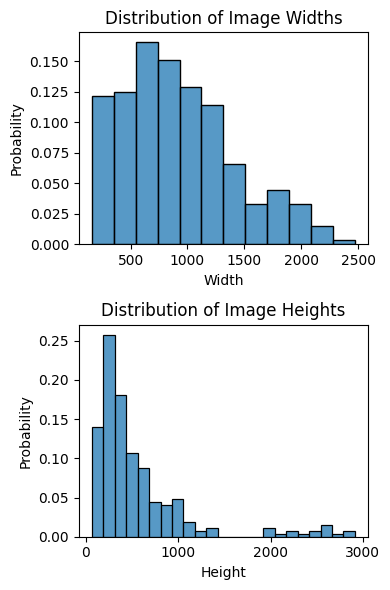

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


# Extract width and height values
widths = [len(image[0]) for image in MD.data.image]
heights = [len(image) for image in MD.data.image]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(4,6))
#fig.suptitle('Histogram of Primary Dataset image sizes')

# Plot width distribution
sns.histplot(widths, ax=axs[0], cumulative=False, stat='probability')

axs[0].set_xlabel('Width')
axs[0].set_ylabel('Probability')
axs[0].set_title('Distribution of Image Widths')

# Plot height distribution
sns.histplot(heights,ax=axs[1], cumulative=False, stat='probability')
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Probability')
axs[1].set_title('Distribution of Image Heights')
plt.tight_layout()

# Display the plots

plt.show()


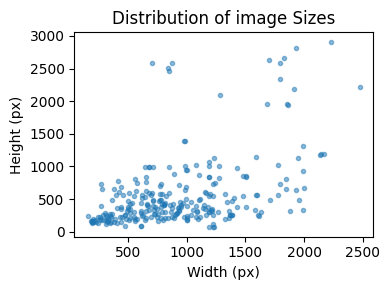

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract width and height values
widths = [len(image[0]) for image in MD.data.image]
heights = [len(image) for image in MD.data.image]

# Create a scatter plot
fig, ax = plt.subplots(figsize=(4, 3))
#fig.suptitle('Scatter Plot of Image Sizes')

# Plot scatter points for width and height
ax.scatter(widths, heights, marker='.', alpha=0.5)

ax.set_xlabel('Width (px)')
ax.set_ylabel('Height (px)')
ax.set_title('Distribution of image Sizes')

plt.tight_layout()

# Display the plot
plt.show()


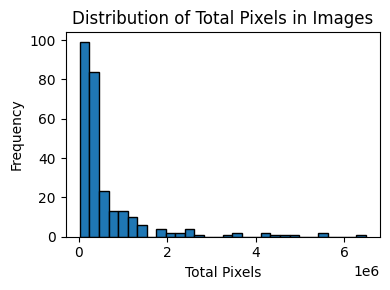

In [46]:
import matplotlib.pyplot as plt

# Calculate total number of pixels for each image
pixel_counts = [len(image) * len(image[0]) for image in MD.data.image]

# Create a histogram
fig, ax = plt.subplots(figsize=(4,3 ))

# Plot the histogram
ax.hist(pixel_counts, bins=30, edgecolor='black')

ax.set_xlabel('Total Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Total Pixels in Images')

plt.tight_layout()

# Display the histogram
plt.show()
